## Обработка семейного фотоальбома в DataSphere

В этом простом примере мы покажем вам, как обработать фотографии из вашего семейного фотоальбома с помощью модели обнаружения объектов YOLO, и как построить на базе этого статистику появления объектов на фото.

Перед выполнением кода ниже убедитесь, что:

1. Вы [создали S3 бакет](https://yandex.cloud/ru/docs/storage/operations/buckets/create) и [загрузили](https://yandex.cloud/ru/docs/storage/operations/objects/upload) туда фотографии из фотоальбома
2. Вы [подключились к хранилищу S3](https://yandex.cloud/ru/docs/datasphere/operations/data/s3-connectors) в DataSphere.

Для начала, установим библиотеку [YOLO v8 от Ultralytics](https://www.ultralytics.com/ru/yolo), которую мы будем использовать для распознавания объектов. Для установки используем стандартную утилиту `pip`, c magic-префиксом `%`.

> При запуске первой ячейки вам будет предложено выбрать конфигурацию вычислительного узла. По возможности, выбирайте конфигурацию с поддержкой GPU, поскольку задача обнаружения объектов может быть ресурсоёмкой.
Также не забывайте останавливать узлы, когда вы ими не пользуетесь - это минимизирует ваши расходы. По умолчанию, DataSphere сама останавливает узел после 4 часов без активостей (это значение можно изменить в настройках проекта/сообщества).

In [1]:
%pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 9.9 MB/s eta 0:00:00:00:010:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


На этом этапе **нужно обязательно перезапустить ядро ноутбука**, чтобы новая библиотека корректно работала. Выберите в меню **Kernel** -> **Restart Kernel**.

Далее создадим объект для детекции объектов на изображении:

In [1]:
from ultralytics import YOLO
detector = YOLO()

100%|██████████| 6.23M/6.23M [00:00<00:00, 41.0MB/s]


Возьмём первый попавшийся файл из нашего S3-хранилища, и применим к нему детекцию объектов. 

In [7]:
from glob import glob
from PIL import Image

src_dir = "/home/jupyter/datasphere/s3/photoarch"

fname = glob(src_dir+"/*")[0]
img = Image.open(fname)
res = detector(img)
print(res)


0: 480x640 1 person, 1 teddy bear, 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 184.7ms postprocess per image at shape (1, 3, 480, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 4

Получим список имен классов, найденных на изображении:

In [10]:
def get_classes(res):
    if len(res)==0:
        return []
    else:
        names = res[0].names
        return [names[int(x)] for x in res[0].boxes.cls]
    
get_classes(res)

['person', 'teddy bear']

Теперь пройдёмся по всем изображениям из архива, и соберём статистику по классам:

In [16]:
from tqdm.auto import tqdm

stat = {}
for fn in tqdm(glob(src_dir+"/*")):
    f = fn.split('/')[-1]
    img = Image.open(fn)
    res = detector(img,verbose=False)
    stat[f] = get_classes(res)

100%|██████████| 776/776 [05:34<00:00,  2.32it/s]


Теперь соберём все данные и вычислим суммарное распределение частотности по всем тегам:

In [19]:
from collections import Counter

agg = sum(stat.values(),[])
freq = Counter(agg)
freq

Counter({'car': 87,
         'person': 1045,
         'truck': 14,
         'teddy bear': 24,
         'motorcycle': 2,
         'potted plant': 29,
         'clock': 13,
         'bench': 21,
         'kite': 22,
         'stop sign': 4,
         'umbrella': 30,
         'traffic light': 23,
         'train': 3,
         'parking meter': 1,
         'bird': 24,
         'tv': 58,
         'giraffe': 6,
         'dog': 27,
         'keyboard': 38,
         'book': 32,
         'chair': 19,
         'tie': 8,
         'handbag': 6,
         'bus': 8,
         'sink': 1,
         'bowl': 28,
         'donut': 2,
         'toilet': 4,
         'backpack': 5,
         'skateboard': 12,
         'suitcase': 14,
         'bottle': 9,
         'cell phone': 7,
         'vase': 5,
         'cat': 6,
         'cup': 7,
         'knife': 2,
         'boat': 69,
         'sheep': 5,
         'surfboard': 14,
         'fire hydrant': 2,
         'cake': 4,
         'cow': 3,
         'bed': 3,
   

Оставим только те объекты, которые встречаются более 10 раз, и построим это в виде графика:

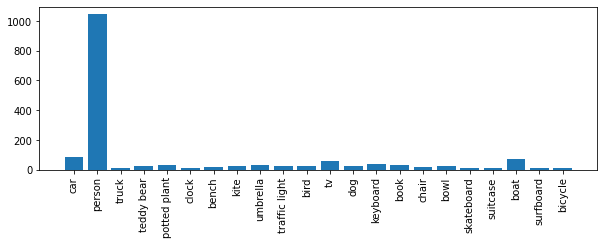

In [24]:
import matplotlib.pyplot as plt

f = { k : v for k,v in freq.items() if v>=10 }

plt.figure(figsize=(10,3))
plt.bar(f.keys(),f.values())
plt.xticks(rotation=90)
plt.show()

Посмотрим на картинки, содержащие зонтики.

> Эта ячейка может выпольняться достаточно долго, т.к. узким местом является время загрузки из хранилища S3 

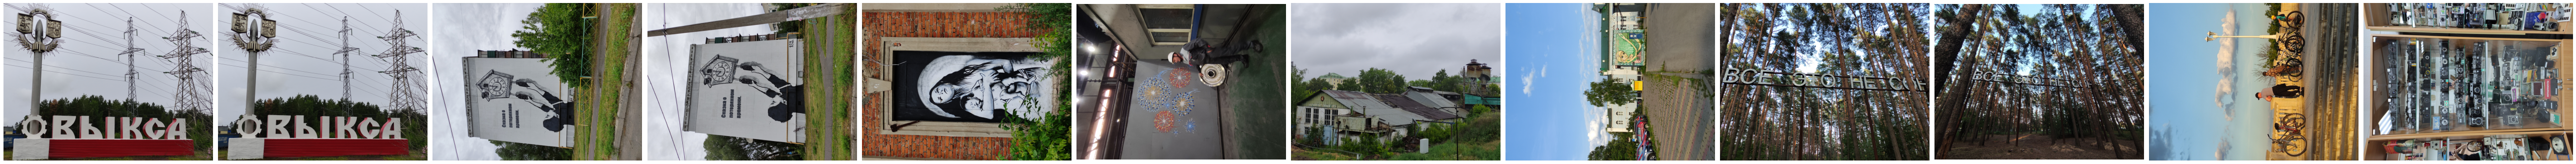

In [30]:
cls = 'clock'

imgs = [ Image.open(f"{src_dir}/{k}") for k,v in stat.items() if cls in v ]

def display_images(l):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()
    
display_images(imgs)

## Заключение

В данной работе мы посмотрели, как DataSphere может работать с внешними объектными хранилищами данных, а также как можно устанавливать дополнительные пакеты и работать с предобученными моделями в среде Jupyter Lab.